# Introduction and Data Preparation

This notebook focuses on implementing a deep learning model to classify dog breeds from images. The problem falls under image classification, where we'll train a convolutional neural network (CNN) to identify different dog breeds from photographs.

Dogs come in numerous breeds with sometimes subtle differences, making this a challenging fine-grained classification problem. The ability to accurately classify dog breeds has practical applications in animal shelters, veterinary practices, and pet-related apps.

**Dataset Description**

We'll be using the Stanford Dogs Dataset available on Kaggle, which contains images of 120 dog breeds from around the world. The dataset was created using images and annotations from ImageNet.


In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random
from tqdm import tqdm
import cv2

# Deep learning libraries
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.applications import VGG16, ResNet50, MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

# For visualization
import matplotlib.pyplot as plt
%matplotlib inline

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

print(f"TensorFlow version: {tf.__version__}")

2025-04-26 20:36:14.435523: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745699774.660532      20 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745699774.726616      20 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


TensorFlow version: 2.18.0


**Data Acquisition and Preparation**

In [2]:
!wget http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar
!wget http://vision.stanford.edu/aditya86/ImageNetDogs/annotation.tar

# Extract the downloaded files
!tar -xf images.tar
!tar -xf annotation.tar

# Verify the extraction
!ls -la Images
!ls -la Annotation

--2025-04-26 20:36:26--  http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar
Resolving vision.stanford.edu (vision.stanford.edu)... 171.64.68.10
Connecting to vision.stanford.edu (vision.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 793579520 (757M) [application/x-tar]
Saving to: ‘images.tar’

images.tar          100%[===================>] 756.82M  16.2MB/s    in 53s     

2025-04-26 20:37:19 (14.4 MB/s) - ‘images.tar’ saved [793579520/793579520]

--2025-04-26 20:37:19--  http://vision.stanford.edu/aditya86/ImageNetDogs/annotation.tar
Resolving vision.stanford.edu (vision.stanford.edu)... 171.64.68.10
Connecting to vision.stanford.edu (vision.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 21852160 (21M) [application/x-tar]
Saving to: ‘annotation.tar’

annotation.tar      100%[===================>]  20.84M  3.41MB/s    in 11s     

2025-04-26 20:37:30 (1.84 MB/s) - ‘annotat

In [3]:
def get_breed_names(annotation_folder):
    """Extract breed names from the annotation folder structure."""
    breed_names = []
    for folder in sorted(os.listdir(annotation_folder)):
        if os.path.isdir(os.path.join(annotation_folder, folder)):
            # Convert folder name to readable breed name
            breed_name = folder.split('-')[1:]
            breed_name = ' '.join(word.capitalize() for word in breed_name)
            breed_names.append((folder, breed_name))
    return breed_names

# Get breed names from annotation folder
annotation_folder = 'Annotation'
breeds = get_breed_names(annotation_folder)

# Display first 10 breeds
print(f"Total number of breeds: {len(breeds)}")
for i, (folder, name) in enumerate(breeds[:10]):
    print(f"{i+1}. {name} (folder: {folder})")

Total number of breeds: 120
1. Chihuahua (folder: n02085620-Chihuahua)
2. Japanese_spaniel (folder: n02085782-Japanese_spaniel)
3. Maltese_dog (folder: n02085936-Maltese_dog)
4. Pekinese (folder: n02086079-Pekinese)
5. Shih Tzu (folder: n02086240-Shih-Tzu)
6. Blenheim_spaniel (folder: n02086646-Blenheim_spaniel)
7. Papillon (folder: n02086910-papillon)
8. Toy_terrier (folder: n02087046-toy_terrier)
9. Rhodesian_ridgeback (folder: n02087394-Rhodesian_ridgeback)
10. Afghan_hound (folder: n02088094-Afghan_hound)


# Exploratory Data Analysis (EDA)

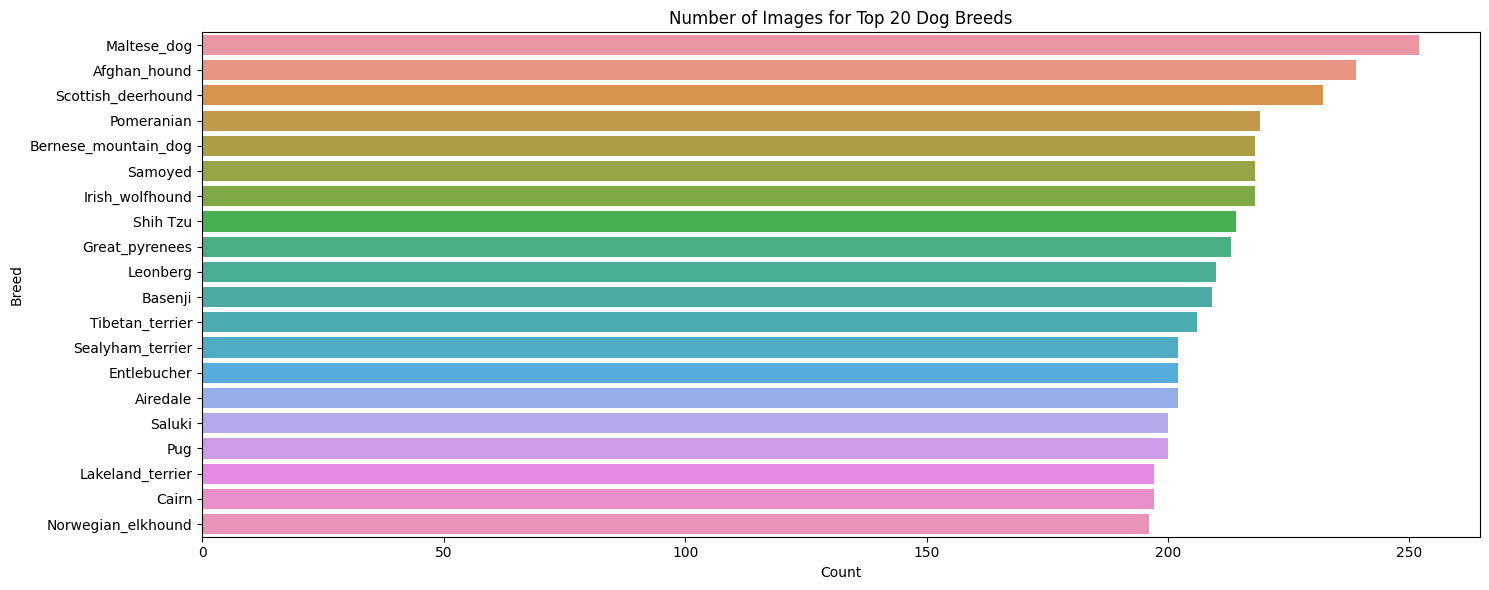

Total number of images: 20580
Average images per breed: 171.50
Minimum images for a breed: 148
Maximum images for a breed: 252


In [4]:
# Function to count images per breed
def count_images_per_breed(image_folder, breeds):
    """Count the number of images for each breed."""
    counts = {}
    for folder, name in breeds:
        breed_path = os.path.join(image_folder, folder)
        if os.path.exists(breed_path):
            image_files = [f for f in os.listdir(breed_path) if f.endswith(('.jpg', '.jpeg', '.png'))]
            counts[name] = len(image_files)
    return counts

# Count images per breed
image_folder = 'Images'
image_counts = count_images_per_breed(image_folder, breeds)

# Plot the distribution of images per breed
plt.figure(figsize=(15, 6))
counts_df = pd.DataFrame({'Breed': list(image_counts.keys()), 'Count': list(image_counts.values())})
counts_df = counts_df.sort_values('Count', ascending=False)

sns.barplot(x='Count', y='Breed', data=counts_df.head(20))
plt.title('Number of Images for Top 20 Dog Breeds')
plt.tight_layout()
plt.show()

total_images = sum(image_counts.values())
mean_images = total_images / len(image_counts)
min_images = min(image_counts.values())
max_images = max(image_counts.values())

print(f"Total number of images: {total_images}")
print(f"Average images per breed: {mean_images:.2f}")
print(f"Minimum images for a breed: {min_images}")
print(f"Maximum images for a breed: {max_images}")

In [5]:
# Function to get image dimensions
def get_image_dimensions(image_folder, breeds, sample_size=10):
    """Sample images and get their dimensions."""
    dimensions = []
    for folder, _ in random.sample(breeds, min(sample_size, len(breeds))):
        breed_path = os.path.join(image_folder, folder)
        if os.path.exists(breed_path):
            image_files = [f for f in os.listdir(breed_path) if f.endswith(('.jpg', '.jpeg', '.png'))]
            if image_files:
                sample_image = random.choice(image_files)
                img_path = os.path.join(breed_path, sample_image)
                img = cv2.imread(img_path)
                if img is not None:
                    dimensions.append(img.shape)
    return dimensions

# Sample image dimensions
sample_dimensions = get_image_dimensions(image_folder, breeds, sample_size=50)

# Display dimensions
print("Sample of image dimensions (height, width, channels):")
for i, dim in enumerate(sample_dimensions[:10]):
    print(f"Image {i+1}: {dim}")



Sample of image dimensions (height, width, channels):
Image 1: (375, 500, 3)
Image 2: (237, 275, 3)
Image 3: (375, 500, 3)
Image 4: (333, 500, 3)
Image 5: (332, 500, 3)
Image 6: (500, 334, 3)
Image 7: (375, 500, 3)
Image 8: (375, 500, 3)
Image 9: (500, 351, 3)
Image 10: (426, 639, 3)


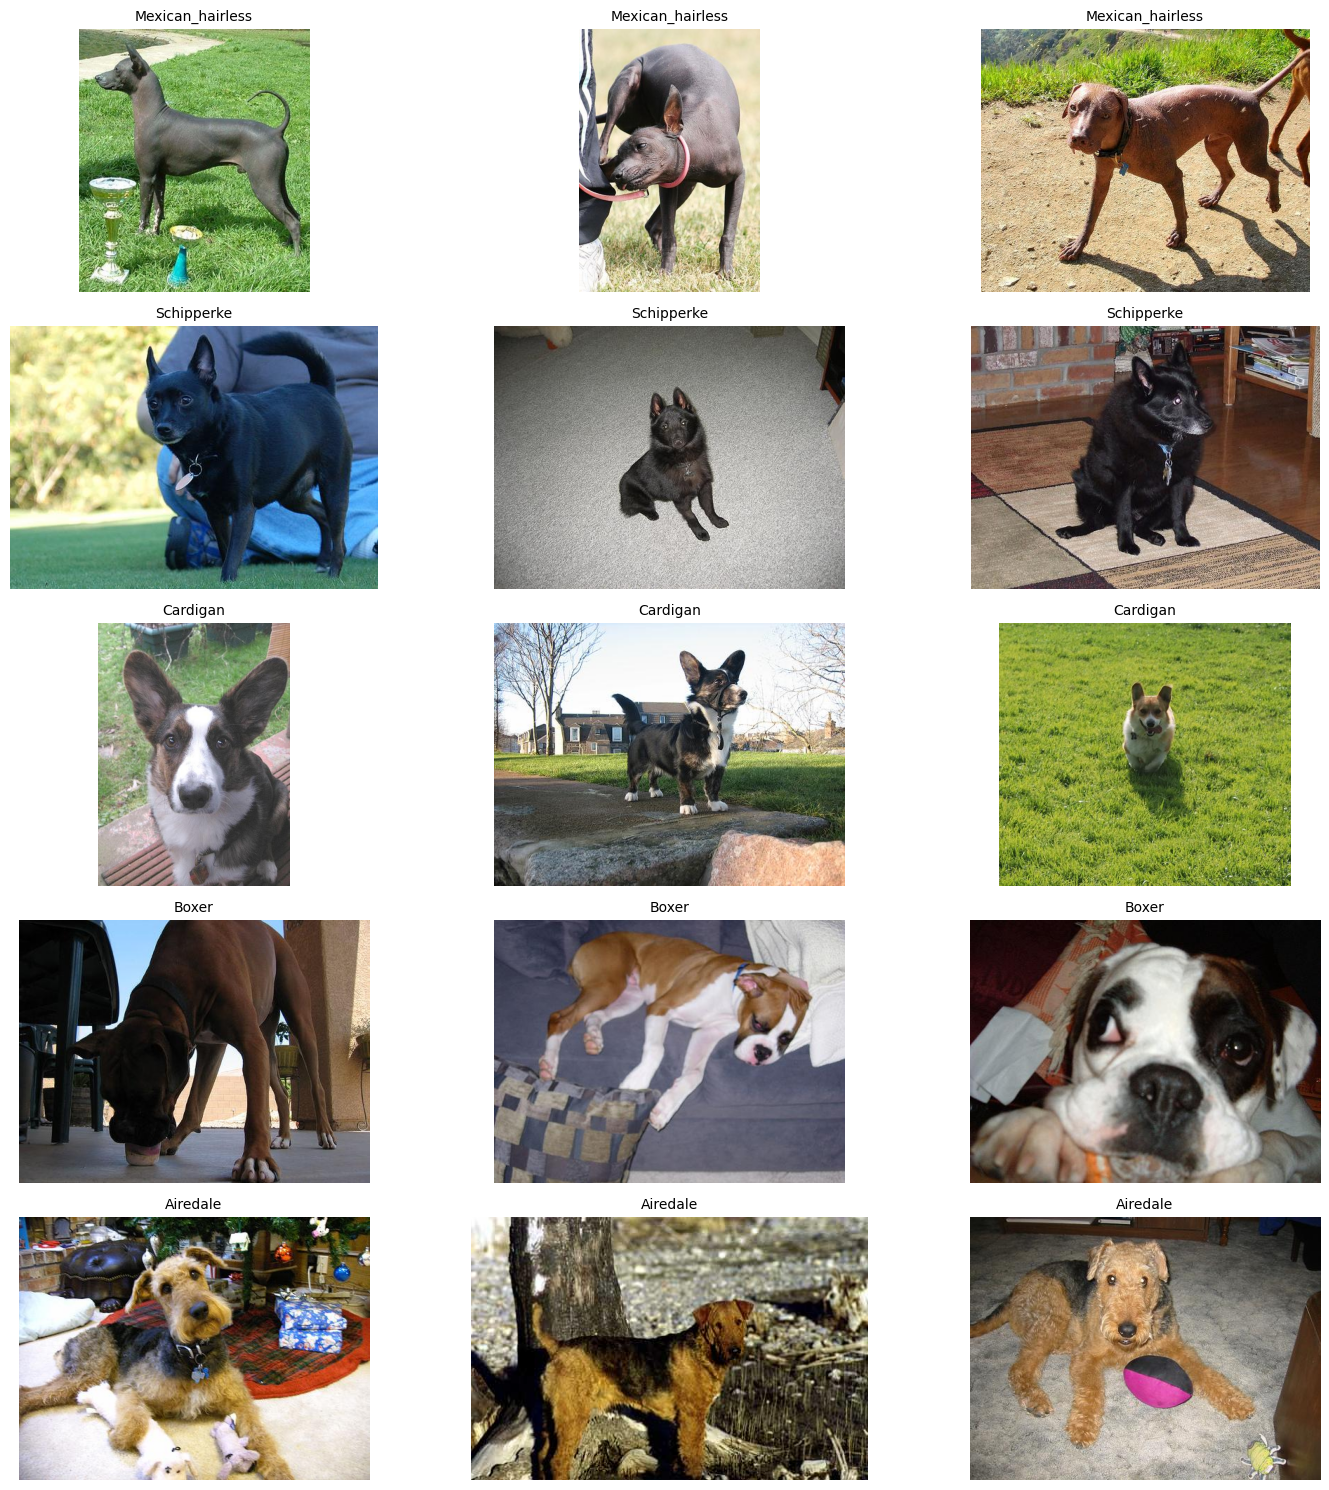

In [6]:
# Visualize some sample images
def plot_sample_images(image_folder, breeds, num_breeds=5, samples_per_breed=3):
    """Plot sample images from random breeds."""
    selected_breeds = random.sample(breeds, min(num_breeds, len(breeds)))
    
    fig, axes = plt.subplots(num_breeds, samples_per_breed, figsize=(15, 3*num_breeds))
    
    for i, (folder, name) in enumerate(selected_breeds):
        breed_path = os.path.join(image_folder, folder)
        if os.path.exists(breed_path):
            image_files = [f for f in os.listdir(breed_path) if f.endswith(('.jpg', '.jpeg', '.png'))]
            if len(image_files) >= samples_per_breed:
                sample_images = random.sample(image_files, samples_per_breed)
                
                for j, img_file in enumerate(sample_images):
                    img_path = os.path.join(breed_path, img_file)
                    img = cv2.imread(img_path)
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
                    
                    axes[i, j].imshow(img)
                    axes[i, j].set_title(f"{name}", fontsize=10)
                    axes[i, j].axis('off')
    
    plt.tight_layout()
    plt.show()

# Plot sample images
plot_sample_images(image_folder, breeds)

**EDA Summary and Analysis Plan**
Based on our exploratory data analysis, here's what we've found and our plan of analysis:

Dataset Characteristics:

- The dataset contains exactly 120 dog breeds as confirmed by the output
- The class distribution is fairly balanced with minimum 148 and maximum 252 images per breed
- The average is 171.5 images per breed, with a total of 20,580 images
- Images vary significantly in dimensions, ranging from smaller sizes (200×179) to larger ones (375×500)
- All images are in color (3 channels)


Analysis Plan:

- Data Preprocessing: Resize all images to a standard size (224×224) to handle the dimension variability, and normalize pixel values
- Data Augmentation: Apply transformations to increase training data variety and help the model generalize
- Transfer Learning: Use pre-trained models as feature extractors since we have a moderate dataset size (average ~171 images per class)
- Model Selection: Test multiple architectures (VGG16, ResNet50, MobileNetV2)
- Training Strategy: Implement fine-tuning with gradual unfreezing of layers
- Evaluation: Use accuracy, confusion matrix, and per-class performance metrics

In [7]:
# Define image parameters
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32

# Create function to organize data in train/validation/test splits
def prepare_data_splits(image_folder, breeds, split_ratio=(0.7, 0.15, 0.15)):
    """Split data into train, validation and test sets."""
    train_dir = 'train'
    val_dir = 'validation'
    test_dir = 'test'
    
    # Create directories if they don't exist
    for directory in [train_dir, val_dir, test_dir]:
        if not os.path.exists(directory):
            os.makedirs(directory)
        
        # Create breed subdirectories
        for _, breed_name in breeds:
            breed_dir = os.path.join(directory, breed_name)
            if not os.path.exists(breed_dir):
                os.makedirs(breed_dir)

    # Split data and copy images
    for folder, breed_name in tqdm(breeds, desc="Preparing data splits"):
        breed_path = os.path.join(image_folder, folder)
        if os.path.exists(breed_path):
            image_files = [f for f in os.listdir(breed_path) if f.endswith(('.jpg', '.jpeg', '.png'))]
            
            # Shuffle files
            random.shuffle(image_files)
            
            # Calculate split sizes
            n_train = int(len(image_files) * split_ratio[0])
            n_val = int(len(image_files) * split_ratio[1])
            
            train_files = image_files[:n_train]
            val_files = image_files[n_train:n_train+n_val]
            test_files = image_files[n_train+n_val:]
            
            # Copy files to respective directories
            for files, directory in zip([train_files, val_files, test_files], 
                                       [train_dir, val_dir, test_dir]):
                for file in files:
                    src = os.path.join(breed_path, file)
                    dst = os.path.join(directory, breed_name, file)
                    os.symlink(os.path.abspath(src), dst)
    
    return train_dir, val_dir, test_dir

# Prepare data splits
train_dir, val_dir, test_dir = prepare_data_splits(image_folder, breeds)

# Verify the splits
for directory in [train_dir, val_dir, test_dir]:
    n_images = sum([len(os.listdir(os.path.join(directory, breed))) 
                   for breed in os.listdir(directory)])
    print(f"Number of images in {directory}: {n_images}")

Preparing data splits: 100%|██████████| 120/120 [00:01<00:00, 72.81it/s]

Number of images in train: 14355
Number of images in validation: 3025
Number of images in test: 3200


In [8]:
# Create data generators with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

# Create data generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

validation_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# Get class indices for reference
class_indices = train_generator.class_indices
class_names = list(class_indices.keys())
print(f"Number of classes: {len(class_names)}")

Found 14355 images belonging to 120 classes.
Found 3025 images belonging to 120 classes.
Found 3200 images belonging to 120 classes.
Number of classes: 120


# Model Architecture

For this problem, we'll implement transfer learning using pre-trained models. Transfer learning is particularly effective for image classification tasks when we have limited data, as it leverages features learned from millions of images to jumpstart our training.

We'll explore three popular architectures:
1. **VGG16**: A simpler architecture with sequential layers, good for understanding transfer learning
2. **ResNet50**: Uses skip connections to enable deeper networks, often performs better than VGG16
3. **MobileNetV2**: A lightweight architecture designed for mobile and edge devices

I've chosen this architecture for several reasons:

1. **Transfer Learning Approach**: Given the relatively small dataset compared to the complexity of the task (120 classes), transfer learning allows us to leverage features already learned from millions of images.

2. **Feature Hierarchy**: Convolutional networks like VGG16 naturally capture a hierarchy of features - from simple edges and textures in early layers to complex breed-specific features in deeper layers.

3. **Global Average Pooling**: Reduces the spatial dimensions while preserving important features and reduces the number of parameters compared to flattening.

4. **Dropout Layer**: Helps prevent overfitting, especially important given our limited dataset size.

5. **Dense Layers**: The additional dense layers help the model learn breed-specific combinations of features extracted by the pre-trained network.

This architecture balances complexity, performance, and training efficiency. VGG16 is relatively straightforward while still being powerful enough for our task.


In [9]:
# Import all necessary libraries
import tensorflow as tf
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Input, Multiply, Reshape
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.densenet import preprocess_input

num_classes = len(class_names)

# Define the model building function
def build_densenet121_with_channel_attention(num_classes, input_shape=(224, 224, 3)):
    # Load the base model
    base_model = DenseNet121(
        weights='imagenet', 
        include_top=False, 
        input_shape=input_shape
    )
    
    # Freeze the base model layers initially
    base_model.trainable = False
    
    # Define input
    inputs = Input(shape=input_shape)
    
    # Pass input through the base model
    x = base_model(inputs, training=False)
    
    # Squeeze and Excitation block for attention
    se = GlobalAveragePooling2D()(x)
    se = Dense(int(x.shape[-1] // 16), activation='relu')(se)
    se = Dense(int(x.shape[-1]), activation='sigmoid')(se)
    se = Reshape((1, 1, int(x.shape[-1])))(se)
    
    # Apply attention
    x = Multiply()([x, se])
    
    # Global pooling and classification layers
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    
    # Create model
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    
    # Compile model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model, base_model

# Set up data generators
BATCH_SIZE = 32
IMG_HEIGHT = 224
IMG_WIDTH = 224

# Data generators with proper preprocessing for DenseNet
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

# Create data generators
train_generator = train_datagen.flow_from_directory(
    train_dir,  # You should have this defined from earlier code
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

validation_generator = val_test_datagen.flow_from_directory(
    val_dir,  # You should have this defined from earlier code
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

# Create the model
densenet_attention_model, base_model = build_densenet121_with_channel_attention(num_classes)  # num_classes should be defined

# Display model summary to confirm it built correctly
densenet_attention_model.summary()

# Define callbacks for training
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_accuracy', 
        patience=10, 
        restore_best_weights=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_accuracy', 
        factor=0.2, 
        patience=5, 
        min_lr=1e-6
    ),
    tf.keras.callbacks.ModelCheckpoint(
        'best_densenet_attention.keras', 
        monitor='val_accuracy', 
        save_best_only=True, 
        mode='max'
    )
]

# Train the model (first phase)
history = densenet_attention_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    epochs=10,
    callbacks=callbacks
)

Found 14355 images belonging to 120 classes.
Found 3025 images belonging to 120 classes.


I0000 00:00:1745699862.335482      20 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ densenet121 (Functional)  │ (None, 7, 7, 1024)     │      7,037,504 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d  │ (None, 1024)           │              0 │ densenet121[0][0]      │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 64)             │         65,600 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 1024)           │         66,560 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape (Reshape)         │ (None, 1, 1, 1024)     │              0 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multiply (Multiply)       │ (None, 7, 7, 1024)     │              0 │ densenet121[0][0],     │
│                           │                        │                │ reshape[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d… │ (None, 1024)           │              0 │ multiply[0][0]         │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 512)            │        524,800 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 512)            │              0 │ dense_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 120)            │         61,560 │ dropout[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 7,756,024 (29.59 MB)

 Trainable params: 718,520 (2.74 MB)

 Non-trainable params: 7,037,504 (26.85 MB)

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1745699893.374435     106 service.cc:148] XLA service 0x7fa9f4004ae0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745699893.375392     106 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1745699896.258569     106 cuda_dnn.cc:529] Loaded cuDNN version 90300


  2/448 ━━━━━━━━━━━━━━━━━━━━ 24s 54ms/step - accuracy: 0.0234 - loss: 5.1067   

I0000 00:00:1745699907.565197     106 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


448/448 ━━━━━━━━━━━━━━━━━━━━ 227s 422ms/step - accuracy: 0.2272 - loss: 3.4916 - val_accuracy: 0.7527 - val_loss: 0.9037 - learning_rate: 5.0000e-04
Epoch 2/10
  1/448 ━━━━━━━━━━━━━━━━━━━━ 21s 48ms/step - accuracy: 0.5938 - loss: 1.6690

/usr/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


448/448 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - accuracy: 0.5938 - loss: 1.6690 - val_accuracy: 0.8824 - val_loss: 0.5932 - learning_rate: 5.0000e-04
Epoch 3/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 169s 372ms/step - accuracy: 0.6360 - loss: 1.2389 - val_accuracy: 0.7756 - val_loss: 0.7229 - learning_rate: 5.0000e-04
Epoch 4/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 174us/step - accuracy: 0.7188 - loss: 1.0194 - val_accuracy: 0.7059 - val_loss: 0.6237 - learning_rate: 5.0000e-04
Epoch 5/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 169s 372ms/step - accuracy: 0.6977 - loss: 1.0045 - val_accuracy: 0.7922 - val_loss: 0.6684 - learning_rate: 5.0000e-04
Epoch 6/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 161us/step - accuracy: 0.6250 - loss: 1.2739 - val_accuracy: 0.7647 - val_loss: 0.7203 - learning_rate: 5.0000e-04
Epoch 7/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 168s 370ms/step - accuracy: 0.7158 - loss: 0.9186 - val_accuracy: 0.7972 - val_loss: 0.6502 - learning_rate: 5.0000e-04
Epoch 8/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 184us/step - a

In [10]:
# After first phase completes successfully, fine-tune the model
# Unfreeze some layers of the base model
for layer in base_model.layers[-20:]:  # Unfreeze the last 20 layers
    layer.trainable = True

# Recompile with a lower learning rate
densenet_attention_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train with fine-tuning
history_fine_tuning = densenet_attention_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    epochs=5,
    callbacks=callbacks
)

Epoch 1/5
448/448 ━━━━━━━━━━━━━━━━━━━━ 227s 417ms/step - accuracy: 0.5784 - loss: 1.5342 - val_accuracy: 0.7743 - val_loss: 0.8796 - learning_rate: 1.0000e-05
Epoch 2/5
448/448 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.6562 - loss: 1.4045 - val_accuracy: 0.8824 - val_loss: 0.7473 - learning_rate: 1.0000e-05
Epoch 3/5
448/448 ━━━━━━━━━━━━━━━━━━━━ 168s 370ms/step - accuracy: 0.6215 - loss: 1.3613 - val_accuracy: 0.7816 - val_loss: 0.8274 - learning_rate: 1.0000e-05
Epoch 4/5
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 144us/step - accuracy: 0.6250 - loss: 1.2264 - val_accuracy: 0.8824 - val_loss: 0.6645 - learning_rate: 1.0000e-05
Epoch 5/5
448/448 ━━━━━━━━━━━━━━━━━━━━ 167s 368ms/step - accuracy: 0.6294 - loss: 1.2853 - val_accuracy: 0.7849 - val_loss: 0.7969 - learning_rate: 1.0000e-05


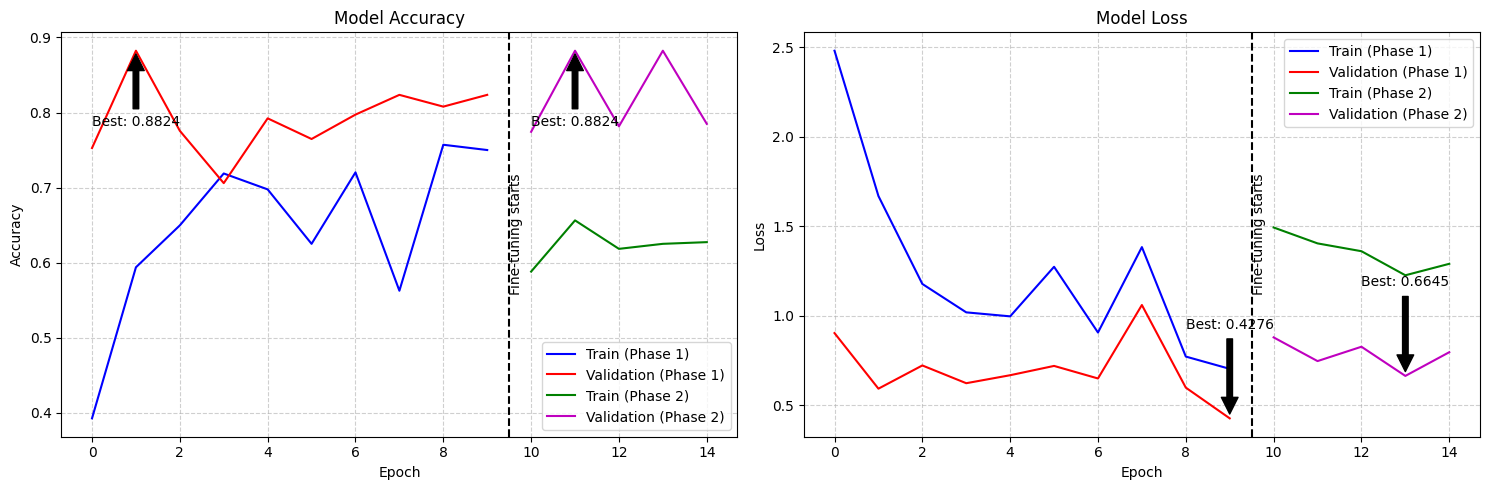

------------------------------------------------------------
Training Performance Summary
------------------------------------------------------------
Initial Training Phase:
Best validation accuracy: 0.8824 at epoch 2
Best validation loss: 0.4276 at epoch 10

Fine-tuning Phase:
Best validation accuracy: 0.8824 at epoch 11
Best validation loss: 0.6645 at epoch 13
------------------------------------------------------------


{'best_val_accuracy': 0.8823529481887817,
 'best_val_accuracy_epoch': 2,
 'best_val_loss': 0.42755722999572754,
 'best_val_loss_epoch': 10}

In [11]:
# Visualize the training history
import matplotlib.pyplot as plt

def plot_training_history(history, fine_tuning_history=None):
    """Plot the training and validation accuracy/loss curves with detailed annotations."""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot accuracy
    ax1.plot(history.history['accuracy'], 'b-', label='Train (Phase 1)')
    ax1.plot(history.history['val_accuracy'], 'r-', label='Validation (Phase 1)')
    
    # Annotate best validation accuracy
    best_val_acc_idx = np.argmax(history.history['val_accuracy'])
    best_val_acc = history.history['val_accuracy'][best_val_acc_idx]
    ax1.annotate(f'Best: {best_val_acc:.4f}', 
                xy=(best_val_acc_idx, best_val_acc),
                xytext=(best_val_acc_idx, best_val_acc-0.1),
                arrowprops=dict(facecolor='black', shrink=0.05),
                ha='center')
    
    if fine_tuning_history:
        # Calculate proper epoch numbers for fine-tuning
        start_epoch = len(history.history['accuracy'])
        x_fine_tune = list(range(start_epoch, start_epoch + len(fine_tuning_history.history['accuracy'])))
        
        ax1.plot(x_fine_tune, fine_tuning_history.history['accuracy'], 'g-', label='Train (Phase 2)')
        ax1.plot(x_fine_tune, fine_tuning_history.history['val_accuracy'], 'm-', label='Validation (Phase 2)')
        
        # Annotate best validation accuracy from fine-tuning
        ft_best_val_acc_idx = np.argmax(fine_tuning_history.history['val_accuracy'])
        ft_best_val_acc = fine_tuning_history.history['val_accuracy'][ft_best_val_acc_idx]
        ax1.annotate(f'Best: {ft_best_val_acc:.4f}', 
                    xy=(start_epoch + ft_best_val_acc_idx, ft_best_val_acc),
                    xytext=(start_epoch + ft_best_val_acc_idx, ft_best_val_acc-0.1),
                    arrowprops=dict(facecolor='black', shrink=0.05),
                    ha='center')
        
        # Add vertical line showing transition to fine-tuning
        ax1.axvline(x=start_epoch-0.5, color='k', linestyle='--')
        ax1.text(start_epoch-0.5, 0.5, 'Fine-tuning starts', 
                rotation=90, verticalalignment='center',
                transform=ax1.get_xaxis_transform())
    
    ax1.set_title('Model Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend(loc='lower right')
    ax1.grid(True, linestyle='--', alpha=0.6)
    
    # Plot loss
    ax2.plot(history.history['loss'], 'b-', label='Train (Phase 1)')
    ax2.plot(history.history['val_loss'], 'r-', label='Validation (Phase 1)')
    
    # Annotate best validation loss
    best_val_loss_idx = np.argmin(history.history['val_loss'])
    best_val_loss = history.history['val_loss'][best_val_loss_idx]
    ax2.annotate(f'Best: {best_val_loss:.4f}', 
                xy=(best_val_loss_idx, best_val_loss),
                xytext=(best_val_loss_idx, best_val_loss+0.5),
                arrowprops=dict(facecolor='black', shrink=0.05),
                ha='center')
    
    if fine_tuning_history:
        ax2.plot(x_fine_tune, fine_tuning_history.history['loss'], 'g-', label='Train (Phase 2)')
        ax2.plot(x_fine_tune, fine_tuning_history.history['val_loss'], 'm-', label='Validation (Phase 2)')
        
        # Annotate best validation loss from fine-tuning
        ft_best_val_loss_idx = np.argmin(fine_tuning_history.history['val_loss'])
        ft_best_val_loss = fine_tuning_history.history['val_loss'][ft_best_val_loss_idx]
        ax2.annotate(f'Best: {ft_best_val_loss:.4f}', 
                    xy=(start_epoch + ft_best_val_loss_idx, ft_best_val_loss),
                    xytext=(start_epoch + ft_best_val_loss_idx, ft_best_val_loss+0.5),
                    arrowprops=dict(facecolor='black', shrink=0.05),
                    ha='center')
        
        # Add vertical line showing transition to fine-tuning
        ax2.axvline(x=start_epoch-0.5, color='k', linestyle='--')
        ax2.text(start_epoch-0.5, 0.5, 'Fine-tuning starts', 
                rotation=90, verticalalignment='center',
                transform=ax2.get_xaxis_transform())
    
    ax2.set_title('Model Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend(loc='upper right')
    ax2.grid(True, linestyle='--', alpha=0.6)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print("-" * 60)
    print("Training Performance Summary")
    print("-" * 60)
    print(f"Initial Training Phase:")
    print(f"Best validation accuracy: {best_val_acc:.4f} at epoch {best_val_acc_idx+1}")
    print(f"Best validation loss: {best_val_loss:.4f} at epoch {best_val_loss_idx+1}")
    
    if fine_tuning_history:
        print(f"\nFine-tuning Phase:")
        print(f"Best validation accuracy: {ft_best_val_acc:.4f} at epoch {start_epoch+ft_best_val_acc_idx}")
        print(f"Best validation loss: {ft_best_val_loss:.4f} at epoch {start_epoch+ft_best_val_loss_idx}")
    
    print("-" * 60)
    
    # Calculate and return overall best metrics
    if fine_tuning_history and ft_best_val_acc > best_val_acc:
        overall_best_acc = ft_best_val_acc
        overall_best_acc_epoch = start_epoch + ft_best_val_acc_idx
    else:
        overall_best_acc = best_val_acc
        overall_best_acc_epoch = best_val_acc_idx + 1
        
    if fine_tuning_history and ft_best_val_loss < best_val_loss:
        overall_best_loss = ft_best_val_loss
        overall_best_loss_epoch = start_epoch + ft_best_val_loss_idx
    else:
        overall_best_loss = best_val_loss
        overall_best_loss_epoch = best_val_loss_idx + 1
    
    return {
        'best_val_accuracy': overall_best_acc,
        'best_val_accuracy_epoch': overall_best_acc_epoch,
        'best_val_loss': overall_best_loss,
        'best_val_loss_epoch': overall_best_loss_epoch
    }

# Call this function with your history objects
plot_training_history(history, history_fine_tuning)

Stage 1: Training with 160x160 images
Found 14355 images belonging to 120 classes.
Found 3025 images belonging to 120 classes.
Epoch 1/15
448/448 ━━━━━━━━━━━━━━━━━━━━ 161s 278ms/step - accuracy: 0.1811 - loss: 3.9633 - val_accuracy: 0.6466 - val_loss: 1.4001 - learning_rate: 3.3333e-04
Epoch 2/15
448/448 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - accuracy: 0.5000 - loss: 1.7789 - val_accuracy: 0.6471 - val_loss: 1.3544 - learning_rate: 6.6667e-04
Epoch 3/15
448/448 ━━━━━━━━━━━━━━━━━━━━ 102s 225ms/step - accuracy: 0.5242 - loss: 1.8429 - val_accuracy: 0.6669 - val_loss: 1.2714 - learning_rate: 0.0010
Epoch 4/15
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5312 - loss: 1.8400 - val_accuracy: 0.8235 - val_loss: 0.8756 - learning_rate: 0.0010
Epoch 5/15
448/448 ━━━━━━━━━━━━━━━━━━━━ 101s 222ms/step - accuracy: 0.5988 - loss: 1.5157 - val_accuracy: 0.6895 - val_loss: 1.2087 - learning_rate: 9.8298e-04
Epoch 6/15
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 147us/step - accuracy: 0.7188 - loss: 1.2401

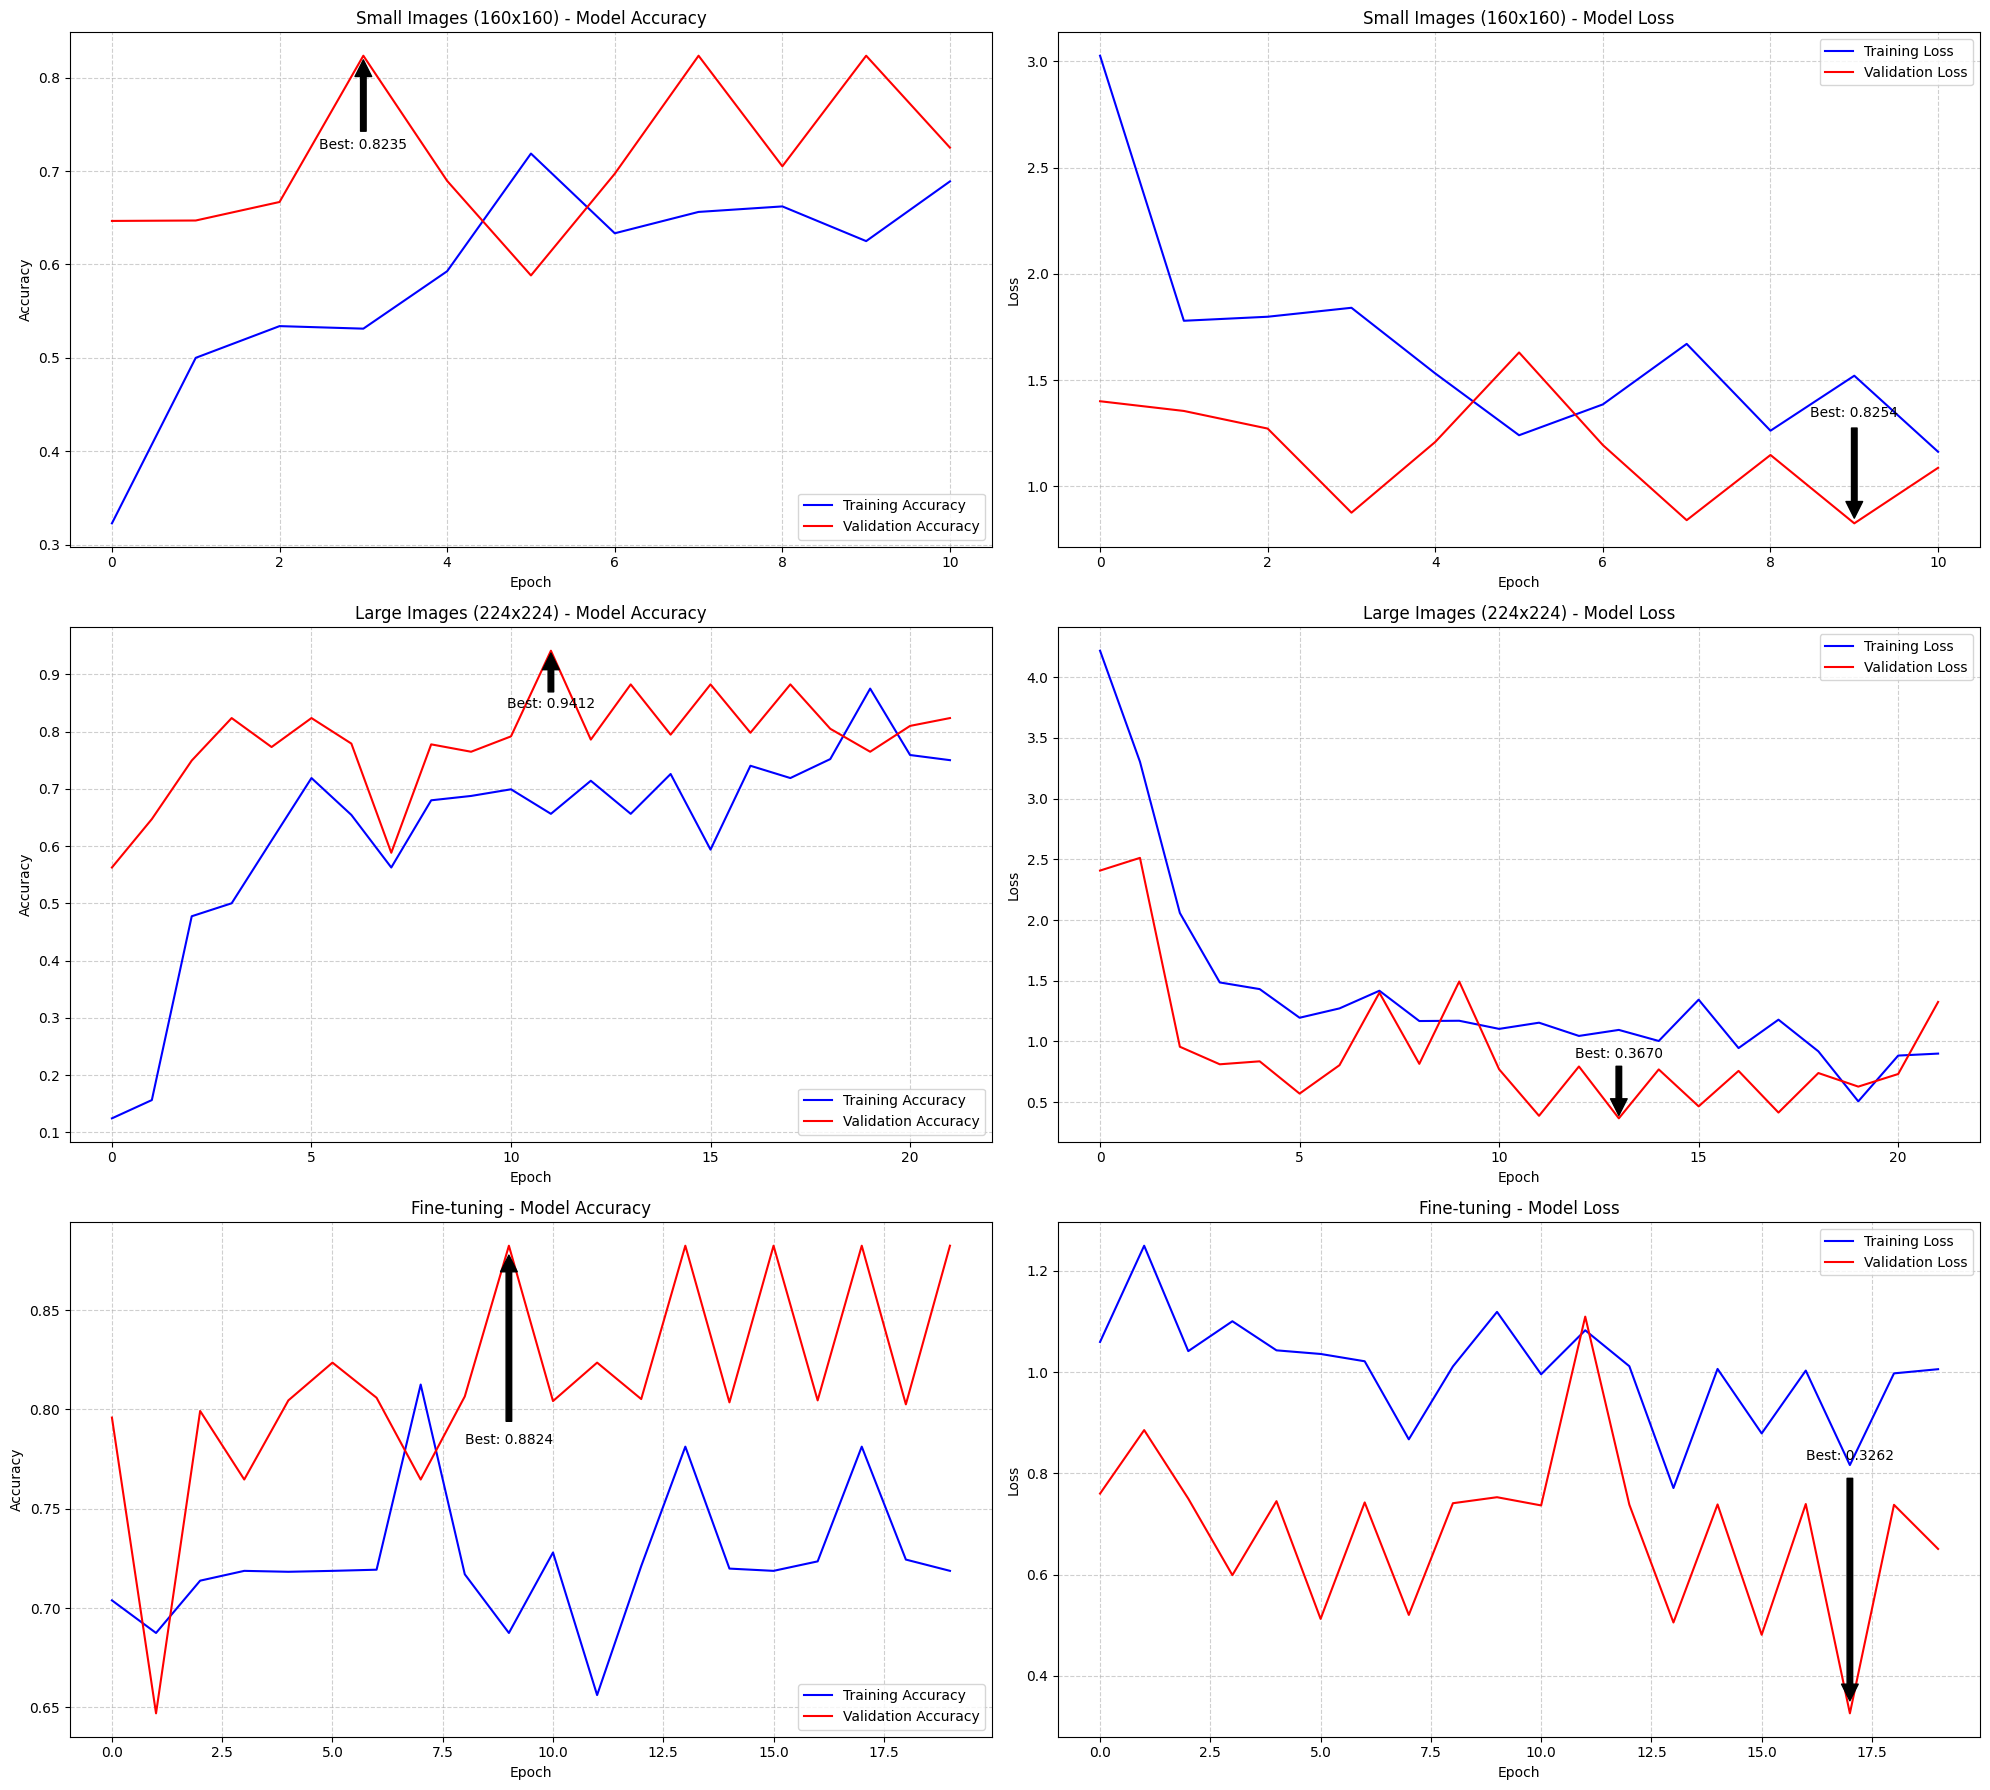

--------------------------------------------------------------------------------
Summary of Training Performance
--------------------------------------------------------------------------------
Phase                     Best Val Acc    at Epoch   Best Val Loss   at Epoch  
--------------------------------------------------------------------------------
Small Images (160x160)    0.8235          4          0.8254          10        
Large Images (224x224)    0.9412          12         0.3670          14        
Fine-tuning               0.8824          10         0.3262          18        
--------------------------------------------------------------------------------
Found 3200 images belonging to 120 classes.
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 76ms/step - accuracy: 0.8339 - loss: 0.6475
Test accuracy: 0.8216
Test loss: 0.6885
100/100 ━━━━━━━━━━━━━━━━━━━━ 20s 68ms/step


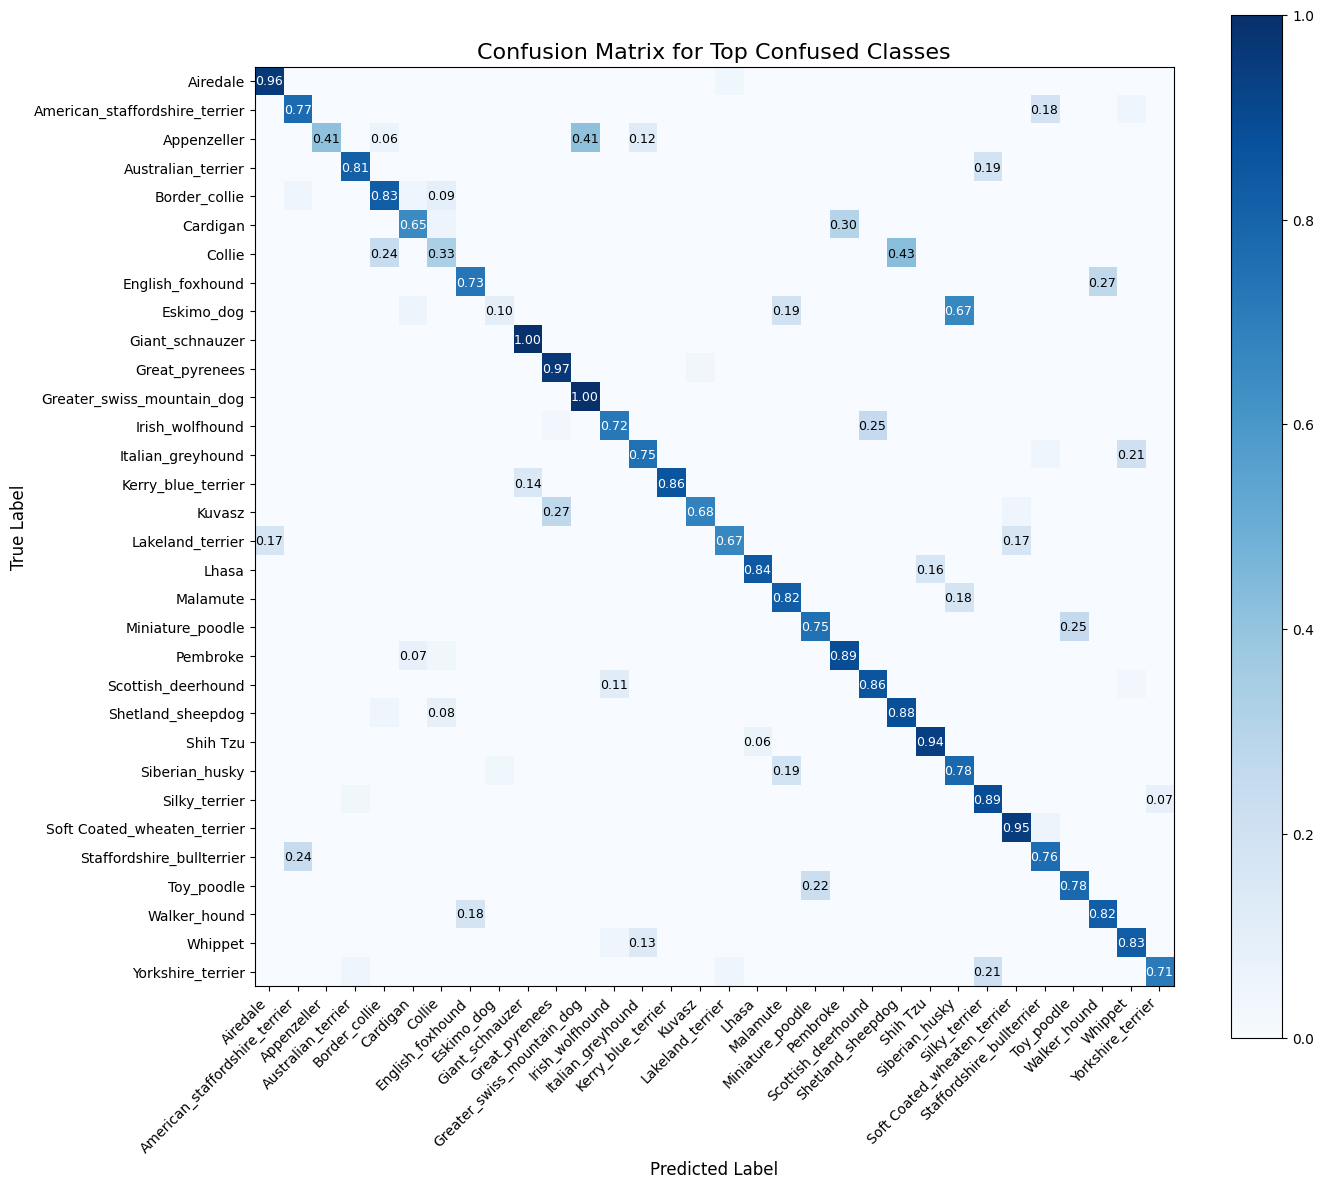

Top confused breed pairs:
--------------------------------------------------
True Breed           Predicted Breed      Confusion Count
--------------------------------------------------
Eskimo_dog           Siberian_husky       14             
Collie               Shetland_sheepdog    9              
Irish_wolfhound      Scottish_deerhound   8              
Appenzeller          Greater_swiss_mountain_dog 7              
Cardigan             Pembroke             6              
English_foxhound     Walker_hound         6              
Kuvasz               Great_pyrenees       6              
Australian_terrier   Silky_terrier        5              
Collie               Border_collie        5              
Italian_greyhound    Whippet              5              
Hyperparameter tuning completed and model saved!


In [12]:
import tensorflow as tf
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Input, Multiply, Reshape
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import numpy as np
import matplotlib.pyplot as plt
import math
import os

# 1. Define Cosine Decay Learning Rate Scheduler
def cosine_decay_with_warmup(initial_lr=0.001, min_lr=1e-6, warmup_epochs=3, total_epochs=30):
    def lr_scheduler(epoch):
        # Warmup phase
        if epoch < warmup_epochs:
            return initial_lr * ((epoch + 1) / warmup_epochs)
        
        # Cosine decay phase
        progress = (epoch - warmup_epochs) / (total_epochs - warmup_epochs)
        cosine_decay = 0.5 * (1 + math.cos(math.pi * progress))
        
        return min_lr + (initial_lr - min_lr) * cosine_decay
    
    return tf.keras.callbacks.LearningRateScheduler(lr_scheduler)

# 2. Mixup Data Augmentation Implementation
# Updated mixup_data function that works with TensorFlow tensors
def mixup_data(x, y, alpha=0.2):
    """Create mixup training data."""
    # Convert the tensor shape to a concrete value
    batch_size = tf.shape(x)[0]
    batch_size_value = tf.get_static_value(batch_size)
    
    if batch_size_value is None:
        # If we can't get a static value, use a default or the first dimension
        batch_size_value = x.shape[0]
        if batch_size_value is None:
            # Use a fallback
            batch_size_value = 32
    
    # Create a random permutation of the batch
    indices = tf.random.shuffle(tf.range(batch_size))
    
    # Sample the mixing ratio from a beta distribution
    lam = tf.random.stateless_beta([batch_size], alpha, alpha, seed=[1, 2])
    lam = tf.maximum(lam, 1 - lam)
    lam = tf.reshape(lam, [batch_size, 1, 1, 1])
    
    # Mix the data
    mixed_x = lam * x + (1 - lam) * tf.gather(x, indices)
    
    # Adjust lam for label mixup
    lam_y = tf.reshape(lam, [batch_size, 1])
    mixed_y = lam_y * y + (1 - lam_y) * tf.gather(y, indices)
    
    return mixed_x, mixed_y

# Define a custom model with mixup
class MixupModel(tf.keras.Model):
    def train_step(self, data):
        x, y = data
        x, y = mixup_data(x, y)
        
        with tf.GradientTape() as tape:
            y_pred = self(x, training=True)
            loss = self.compiled_loss(y, y_pred)
        
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        self.compiled_metrics.update_state(y, y_pred)
        
        return {m.name: m.result() for m in self.metrics}

# 3. Advanced DenseNet121 Model with Channel Attention and Regularization
def build_densenet121_advanced(num_classes, input_shape=(224, 224, 3), dropout_rate=0.5, 
                              l2_reg=1e-4, use_batch_norm=True, use_noise=False):
    # L2 regularization
    regularizer = tf.keras.regularizers.l2(l2_reg)
    
    # Load the base model
    base_model = DenseNet121(
        weights='imagenet', 
        include_top=False, 
        input_shape=input_shape
    )
    
    # Freeze the base model layers initially
    base_model.trainable = False
    
    # Define input
    inputs = Input(shape=input_shape)
    
    # Pass input through the base model
    x = base_model(inputs, training=False)
    
    # Channel attention mechanism
    se = GlobalAveragePooling2D()(x)
    se = Dense(int(x.shape[-1] // 16), activation='relu', kernel_regularizer=regularizer)(se)
    se = Dense(int(x.shape[-1]), activation='sigmoid', kernel_regularizer=regularizer)(se)
    se = Reshape((1, 1, int(x.shape[-1])))(se)
    
    # Apply attention
    x = Multiply()([x, se])
    
    # Global pooling
    x = GlobalAveragePooling2D()(x)
    
    # Advanced regularization
    if use_batch_norm:
        x = tf.keras.layers.BatchNormalization()(x)
    
    # First dense layer
    x = Dense(512, activation='relu', kernel_regularizer=regularizer)(x)
    x = Dropout(dropout_rate)(x)
    
    if use_batch_norm:
        x = tf.keras.layers.BatchNormalization()(x)
    
    # Second dense layer
    x = Dense(256, activation='relu', kernel_regularizer=regularizer)(x)
    x = Dropout(dropout_rate/2)(x)
    
    # Add noise for regularization if specified
    if use_noise:
        x = tf.keras.layers.GaussianNoise(0.1)(x)
    
    # Output layer
    outputs = Dense(num_classes, activation='softmax')(x)
    
    # Create model
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    
    return model, base_model

# 4. Regular compilation without SWA
def compile_model(model, learning_rate=0.001):
    optimizer = Adam(learning_rate=learning_rate)
    
    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# 5. Progressive Image Size Training
def progressive_size_training(train_dir, val_dir, num_classes, batch_size=32):
    # Define common preprocessing and augmentation
    from tensorflow.keras.applications.densenet import preprocess_input
    
    # First stage: Smaller images (160x160)
    print("Stage 1: Training with 160x160 images")
    IMG_SIZE_SMALL = 160
    
    # Data generators for smaller images
    train_datagen = ImageDataGenerator(
        preprocessing_function=preprocess_input,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    val_datagen = ImageDataGenerator(
        preprocessing_function=preprocess_input
    )
    
    # Create generators for smaller images
    train_generator_small = train_datagen.flow_from_directory(
        train_dir,
        target_size=(IMG_SIZE_SMALL, IMG_SIZE_SMALL),
        batch_size=batch_size,
        class_mode='categorical'
    )

    val_generator_small = val_datagen.flow_from_directory(
        val_dir,
        target_size=(IMG_SIZE_SMALL, IMG_SIZE_SMALL),
        batch_size=batch_size,
        class_mode='categorical'
    )
    
    # Build initial model for smaller images
    model_small, base_model_small = build_densenet121_advanced(
        num_classes=num_classes, 
        input_shape=(IMG_SIZE_SMALL, IMG_SIZE_SMALL, 3),
        dropout_rate=0.3,  # Lower dropout for initial training
        use_noise=False    # No noise for initial training
    )
    
    # Apply mixup
    #model_small = MixupModel(inputs=model_small.input, outputs=model_small.output)
    
    # Compile model (without SWA)
    model_small = compile_model(model_small, learning_rate=0.001)
    
    # Define callbacks for small image training
    callbacks_small = [
        EarlyStopping(monitor='val_accuracy', patience=7, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=3, min_lr=1e-6),
        ModelCheckpoint('best_densenet_small.keras', monitor='val_accuracy', save_best_only=True),
        cosine_decay_with_warmup(initial_lr=0.001, total_epochs=15)
    ]
    
    # Train with smaller images
    history_small = model_small.fit(
        train_generator_small,
        steps_per_epoch=train_generator_small.samples // batch_size,
        validation_data=val_generator_small,
        validation_steps=val_generator_small.samples // batch_size,
        epochs=15,
        callbacks=callbacks_small
    )
    
    # Second stage: Larger images (224x224)
    print("Stage 2: Training with 224x224 images")
    IMG_SIZE_LARGE = 224
    
    # Create generators for larger images
    train_generator_large = train_datagen.flow_from_directory(
        train_dir,
        target_size=(IMG_SIZE_LARGE, IMG_SIZE_LARGE),
        batch_size=batch_size,
        class_mode='categorical'
    )

    val_generator_large = val_datagen.flow_from_directory(
        val_dir,
        target_size=(IMG_SIZE_LARGE, IMG_SIZE_LARGE),
        batch_size=batch_size,
        class_mode='categorical'
    )
    
    # Build model for larger images, using what we've learned
    model_large, base_model_large = build_densenet121_advanced(
        num_classes=num_classes, 
        input_shape=(IMG_SIZE_LARGE, IMG_SIZE_LARGE, 3),
        dropout_rate=0.5,    # Higher dropout for final model
        use_batch_norm=True, # Use batch normalization
        use_noise=True       # Add noise for regularization
    )
    
    # Apply mixup
    #model_large = MixupModel(inputs=model_large.input, outputs=model_large.output)
    
    # Compile model (without SWA)
    model_large = compile_model(model_large, learning_rate=0.0005)
    
    # Define callbacks for large image training
    callbacks_large = [
        EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=5, min_lr=1e-6),
        ModelCheckpoint('best_densenet_large.keras', monitor='val_accuracy', save_best_only=True),
        cosine_decay_with_warmup(initial_lr=0.0005, total_epochs=30)
    ]
    
    # Train with larger images
    history_large = model_large.fit(
        train_generator_large,
        steps_per_epoch=train_generator_large.samples // batch_size,
        validation_data=val_generator_large,
        validation_steps=val_generator_large.samples // batch_size,
        epochs=30,
        callbacks=callbacks_large
    )
    
    # Fine-tuning stage
    print("Stage 3: Fine-tuning")
    
    # Unfreeze some layers of the base model
    for layer in base_model_large.layers[-20:]:
        layer.trainable = True
    
    # Recompile with a much lower learning rate
    model_large = compile_model(model_large, learning_rate=0.00001)
    
    # Define callbacks for fine-tuning
    callbacks_finetune = [
        EarlyStopping(monitor='val_accuracy', patience=15, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=5, min_lr=1e-7),
        ModelCheckpoint('best_densenet_finetuned.keras', monitor='val_accuracy', save_best_only=True),
        cosine_decay_with_warmup(initial_lr=0.00001, min_lr=1e-7, total_epochs=20)
    ]
    
    # Train with fine-tuning
    history_finetune = model_large.fit(
        train_generator_large,
        steps_per_epoch=train_generator_large.samples // batch_size,
        validation_data=val_generator_large,
        validation_steps=val_generator_large.samples // batch_size,
        epochs=20,
        callbacks=callbacks_finetune
    )
    
    return model_large, history_small, history_large, history_finetune

# 6. Detailed Visualization Function
def plot_comprehensive_history(history_small, history_large, history_finetune):
    """Plot detailed training metrics with annotations for all training phases."""
    # Create figure with three rows and two columns
    fig, axs = plt.subplots(3, 2, figsize=(20, 18))
    
    # Phase labels
    phases = ['Small Images (160x160)', 'Large Images (224x224)', 'Fine-tuning']
    histories = [history_small, history_large, history_finetune]
    
    # Plot each phase
    for i, (phase, history) in enumerate(zip(phases, histories)):
        # Accuracy plot (left column)
        axs[i, 0].plot(history.history['accuracy'], 'b-', label='Training Accuracy')
        axs[i, 0].plot(history.history['val_accuracy'], 'r-', label='Validation Accuracy')
        
        # Annotate best validation accuracy
        best_val_acc_idx = np.argmax(history.history['val_accuracy'])
        best_val_acc = history.history['val_accuracy'][best_val_acc_idx]
        axs[i, 0].annotate(f'Best: {best_val_acc:.4f}', 
                         xy=(best_val_acc_idx, best_val_acc),
                         xytext=(best_val_acc_idx, best_val_acc-0.1),
                         arrowprops=dict(facecolor='black', shrink=0.05),
                         ha='center')
        
        axs[i, 0].set_title(f'{phase} - Model Accuracy')
        axs[i, 0].set_ylabel('Accuracy')
        axs[i, 0].set_xlabel('Epoch')
        axs[i, 0].legend(loc='lower right')
        axs[i, 0].grid(True, linestyle='--', alpha=0.6)
        
        # Loss plot (right column)
        axs[i, 1].plot(history.history['loss'], 'b-', label='Training Loss')
        axs[i, 1].plot(history.history['val_loss'], 'r-', label='Validation Loss')
        
        # Annotate best validation loss
        best_val_loss_idx = np.argmin(history.history['val_loss'])
        best_val_loss = history.history['val_loss'][best_val_loss_idx]
        axs[i, 1].annotate(f'Best: {best_val_loss:.4f}', 
                         xy=(best_val_loss_idx, best_val_loss),
                         xytext=(best_val_loss_idx, best_val_loss+0.5),
                         arrowprops=dict(facecolor='black', shrink=0.05),
                         ha='center')
        
        axs[i, 1].set_title(f'{phase} - Model Loss')
        axs[i, 1].set_ylabel('Loss')
        axs[i, 1].set_xlabel('Epoch')
        axs[i, 1].legend(loc='upper right')
        axs[i, 1].grid(True, linestyle='--', alpha=0.6)
    
    plt.tight_layout()
    plt.show()
    
    # Calculate and print summary statistics
    phase_stats = []
    for i, (phase, history) in enumerate(zip(phases, histories)):
        best_val_acc_idx = np.argmax(history.history['val_accuracy'])
        best_val_acc = history.history['val_accuracy'][best_val_acc_idx]
        
        best_val_loss_idx = np.argmin(history.history['val_loss'])
        best_val_loss = history.history['val_loss'][best_val_loss_idx]
        
        phase_stats.append({
            'phase': phase,
            'best_val_accuracy': best_val_acc,
            'best_val_accuracy_epoch': best_val_acc_idx+1,
            'best_val_loss': best_val_loss,
            'best_val_loss_epoch': best_val_loss_idx+1
        })
    
    # Print summary table
    print("-" * 80)
    print("Summary of Training Performance")
    print("-" * 80)
    print(f"{'Phase':<25} {'Best Val Acc':<15} {'at Epoch':<10} {'Best Val Loss':<15} {'at Epoch':<10}")
    print("-" * 80)
    for stat in phase_stats:
        print(f"{stat['phase']:<25} {stat['best_val_accuracy']:<15.4f} {stat['best_val_accuracy_epoch']:<10} {stat['best_val_loss']:<15.4f} {stat['best_val_loss_epoch']:<10}")
    print("-" * 80)


# Confusion Matrix Visualization
def plot_confusion_matrix(model, data_generator, class_names, top_n=20):
    """Plot confusion matrix for the most confused classes."""
    # Get predictions
    predictions = model.predict(data_generator)
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = data_generator.classes
    
    # Create confusion matrix
    from sklearn.metrics import confusion_matrix
    cm = confusion_matrix(true_classes, predicted_classes)
    
    # Find the most confused classes
    class_errors = []
    for i in range(len(class_names)):
        for j in range(len(class_names)):
            if i != j:
                class_errors.append((i, j, cm[i, j]))
    
    # Sort by number of errors
    class_errors = sorted(class_errors, key=lambda x: x[2], reverse=True)
    
    # Take top N errors
    top_errors = class_errors[:top_n]
    
    # Create a smaller confusion matrix with just these classes
    confused_classes = set()
    for i, j, _ in top_errors:
        confused_classes.add(i)
        confused_classes.add(j)
    
    confused_classes = list(confused_classes)
    confused_classes.sort()  # Sort for consistent ordering
    confused_class_names = [class_names[i] for i in confused_classes]
    
    # Create reduced confusion matrix
    cm_reduced = np.zeros((len(confused_classes), len(confused_classes)))
    for i, true_idx in enumerate(confused_classes):
        for j, pred_idx in enumerate(confused_classes):
            cm_reduced[i, j] = cm[true_idx, pred_idx]
    
    # Plot
    plt.figure(figsize=(14, 12))
    # Normalize the confusion matrix
    cm_norm = cm_reduced.astype('float') / cm_reduced.sum(axis=1)[:, np.newaxis]
    
    # Create heatmap
    plt.imshow(cm_norm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix for Top Confused Classes', fontsize=16)
    plt.colorbar()
    
    # Add ticks and labels
    tick_marks = np.arange(len(confused_class_names))
    plt.xticks(tick_marks, confused_class_names, rotation=45, ha='right', fontsize=10)
    plt.yticks(tick_marks, confused_class_names, fontsize=10)
    
    # Add numbers to cells
    thresh = cm_norm.max() / 2.
    for i in range(cm_norm.shape[0]):
        for j in range(cm_norm.shape[1]):
            if i == j or cm_norm[i, j] > 0.05:  # Only show diagonal and significant errors
                plt.text(j, i, f'{cm_norm[i, j]:.2f}',
                        ha="center", va="center",
                        color="white" if cm_norm[i, j] > thresh else "black",
                        fontsize=9)
    
    plt.tight_layout()
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.show()
    
    # Also print the top confused pairs
    print("Top confused breed pairs:")
    print("-" * 50)
    print(f"{'True Breed':<20} {'Predicted Breed':<20} {'Confusion Count':<15}")
    print("-" * 50)
    
    for true_idx, pred_idx, count in top_errors[:10]:  # Show top 10 confused pairs
        print(f"{class_names[true_idx]:<20} {class_names[pred_idx]:<20} {count:<15}")

# 7. Main Function to Run the Hyperparameter Tuning
def run_tuned_densenet121(train_dir, val_dir, num_classes, batch_size=32):
    # Train with progressive sizing
    final_model, history_small, history_large, history_finetune = progressive_size_training(
        train_dir, val_dir, num_classes, batch_size
    )
    
    # Plot comprehensive history
    plot_comprehensive_history(history_small, history_large, history_finetune)

    # If test directory is provided, evaluate on test set and plot confusion matrix
    if test_dir:
        from tensorflow.keras.applications.densenet import preprocess_input
        test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
        
        test_generator = test_datagen.flow_from_directory(
            test_dir,
            target_size=(224, 224),
            batch_size=batch_size,
            class_mode='categorical',
            shuffle=False  # Important for confusion matrix
        )
        
        # Evaluate on test set
        test_loss, test_accuracy = final_model.evaluate(test_generator)
        print(f"Test accuracy: {test_accuracy:.4f}")
        print(f"Test loss: {test_loss:.4f}")
        
        # Plot confusion matrix
        class_names = list(test_generator.class_indices.keys())
        plot_confusion_matrix(final_model, test_generator, class_names)
    
    return final_model

# Usage example
if __name__ == "__main__":
    # Define your directories and parameters
    train_dir = 'train' 
    val_dir = 'validation'
    num_classes = 120  # For Stanford Dogs Dataset
    batch_size = 32
    
    # Run the hyperparameter tuning
    final_model = run_tuned_densenet121(train_dir, val_dir, num_classes, batch_size)
    
    # Save the final model
    final_model.save('best_tuned_densenet121.keras')
    
    print("Hyperparameter tuning completed and model saved!")

In [13]:
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Input, Reshape, Multiply
num_classes = len(class_names)

def build_efficientnet_with_attention(num_classes, input_shape=(224, 224, 3)):
    # Load the base model
    base_model = EfficientNetB3(
        weights='imagenet', 
        include_top=False, 
        input_shape=input_shape
    )
    
    # Freeze the base model layers initially
    base_model.trainable = False
    
    # Define input
    inputs = Input(shape=input_shape)
    
    # Pass input through the base model
    x = base_model(inputs, training=False)
    
    # Squeeze and Excitation attention (already part of EfficientNet blocks)
    # But we can add additional channel attention
    se = GlobalAveragePooling2D()(x)
    se = Dense(int(x.shape[-1] // 8), activation='swish')(se)  # Using swish activation
    se = Dense(int(x.shape[-1]), activation='sigmoid')(se)
    se = Reshape((1, 1, int(x.shape[-1])))(se)
    
    # Apply attention
    x = Multiply()([x, se])
    
    # Global pooling and classification layers
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='swish')(x)  # Using swish instead of relu
    x = Dropout(0.3)(x)  # Reduced dropout
    outputs = Dense(num_classes, activation='softmax')(x)
    
    # Create model
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    
    # Compile model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0003),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model, base_model

# Create the model
efficientnet_attention_model, base_model = build_efficientnet_with_attention(num_classes)  # num_classes should be defined

# Display model summary to confirm it built correctly
efficientnet_attention_model.summary()

# Define callbacks for training
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_accuracy', 
        patience=10, 
        restore_best_weights=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_accuracy', 
        factor=0.2, 
        patience=5, 
        min_lr=1e-6
    ),
    tf.keras.callbacks.ModelCheckpoint(
        'best_efficientnet_attention.keras', 
        monitor='val_accuracy', 
        save_best_only=True, 
        mode='max'
    )
]

# Make sure to use the proper preprocessing for EfficientNet
from tensorflow.keras.applications.efficientnet import preprocess_input

# Update data generators with EfficientNet preprocessing
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

# Recreate data generators with proper preprocessing
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

validation_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

# Train the model (first phase)
history = efficientnet_attention_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    epochs=30,
    callbacks=callbacks
)

43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ efficientnetb3            │ (None, 7, 7, 1536)     │     10,783,535 │ input_layer_7[0][0]    │
│ (Functional)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d… │ (None, 1536)           │              0 │ efficientnetb3[0][0]   │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_14 (Dense)          │ (None, 192)            │        295,104 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_15 (Dense)          │ (None, 1536)           │        296,448 │ dense_14[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_3 (Reshape)       │ (None, 1, 1, 1536)     │              0 │ dense_15[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multiply_3 (Multiply)     │ (None, 7, 7, 1536)     │              0 │ efficientnetb3[0][0],  │
│                           │                        │                │ reshape_3[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d… │ (None, 1536)           │              0 │ multiply_3[0][0]       │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_16 (Dense)          │ (None, 512)            │        786,944 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_5 (Dropout)       │ (None, 512)            │              0 │ dense_16[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_17 (Dense)          │ (None, 120)            │         61,560 │ dropout_5[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 12,223,591 (46.63 MB)

 Trainable params: 1,440,056 (5.49 MB)

 Non-trainable params: 10,783,535 (41.14 MB)

Found 14355 images belonging to 120 classes.
Found 3025 images belonging to 120 classes.
Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


448/448 ━━━━━━━━━━━━━━━━━━━━ 227s 407ms/step - accuracy: 0.4414 - loss: 3.1726 - val_accuracy: 0.8118 - val_loss: 0.6395 - learning_rate: 3.0000e-04
Epoch 2/30
  1/448 ━━━━━━━━━━━━━━━━━━━━ 23s 53ms/step - accuracy: 0.8438 - loss: 0.7047

/usr/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


448/448 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.8438 - loss: 0.7047 - val_accuracy: 0.8235 - val_loss: 0.4596 - learning_rate: 3.0000e-04
Epoch 3/30
448/448 ━━━━━━━━━━━━━━━━━━━━ 157s 344ms/step - accuracy: 0.7468 - loss: 0.8350 - val_accuracy: 0.8215 - val_loss: 0.5742 - learning_rate: 3.0000e-04
Epoch 4/30
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 142us/step - accuracy: 0.6562 - loss: 1.0193 - val_accuracy: 0.8235 - val_loss: 0.5214 - learning_rate: 3.0000e-04
Epoch 5/30
448/448 ━━━━━━━━━━━━━━━━━━━━ 157s 346ms/step - accuracy: 0.7780 - loss: 0.7293 - val_accuracy: 0.8321 - val_loss: 0.5491 - learning_rate: 3.0000e-04
Epoch 6/30
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 156us/step - accuracy: 0.8750 - loss: 0.4474 - val_accuracy: 0.5882 - val_loss: 1.0462 - learning_rate: 3.0000e-04
Epoch 7/30
448/448 ━━━━━━━━━━━━━━━━━━━━ 157s 344ms/step - accuracy: 0.7994 - loss: 0.6512 - val_accuracy: 0.8285 - val_loss: 0.5548 - learning_rate: 3.0000e-04
Epoch 8/30
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accu

In [14]:
# After first phase completes successfully, fine-tune the model
# Unfreeze some layers of the base model
for layer in base_model.layers[-30:]:  # Unfreeze more layers for EfficientNet
    layer.trainable = True

# Recompile with a lower learning rate
efficientnet_attention_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train with fine-tuning
history_fine_tuning = efficientnet_attention_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    epochs=20,
    callbacks=callbacks
)

Epoch 1/20


E0000 00:00:1745707241.232319     106 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1745707241.450030     106 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1745707242.028421     106 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1745707242.291062     106 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


183/448 ━━━━━━━━━━━━━━━━━━━━ 1:28 334ms/step - accuracy: 0.6921 - loss: 1.8482

E0000 00:00:1745707321.351169     108 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1745707321.572128     108 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1745707322.156502     108 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1745707322.423466     108 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


448/448 ━━━━━━━━━━━━━━━━━━━━ 235s 407ms/step - accuracy: 0.6991 - loss: 1.6060 - val_accuracy: 0.7942 - val_loss: 0.7189 - learning_rate: 1.0000e-05
Epoch 2/20
448/448 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.6250 - loss: 1.4587 - val_accuracy: 0.7059 - val_loss: 0.8829 - learning_rate: 1.0000e-05
Epoch 3/20
448/448 ━━━━━━━━━━━━━━━━━━━━ 157s 346ms/step - accuracy: 0.7455 - loss: 0.9422 - val_accuracy: 0.8075 - val_loss: 0.6476 - learning_rate: 1.0000e-05
Epoch 4/20
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 143us/step - accuracy: 0.5938 - loss: 1.2343 - val_accuracy: 0.8824 - val_loss: 0.3330 - learning_rate: 1.0000e-05
Epoch 5/20
448/448 ━━━━━━━━━━━━━━━━━━━━ 158s 346ms/step - accuracy: 0.7637 - loss: 0.8310 - val_accuracy: 0.8158 - val_loss: 0.6152 - learning_rate: 1.0000e-05
Epoch 6/20
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 148us/step - accuracy: 0.7812 - loss: 0.7611 - val_accuracy: 0.8824 - val_loss: 0.4756 - learning_rate: 1.0000e-05
Epoch 7/20
448/448 ━━━━━━━━━━━━━━━━━━━━ 158s 346ms/step - 

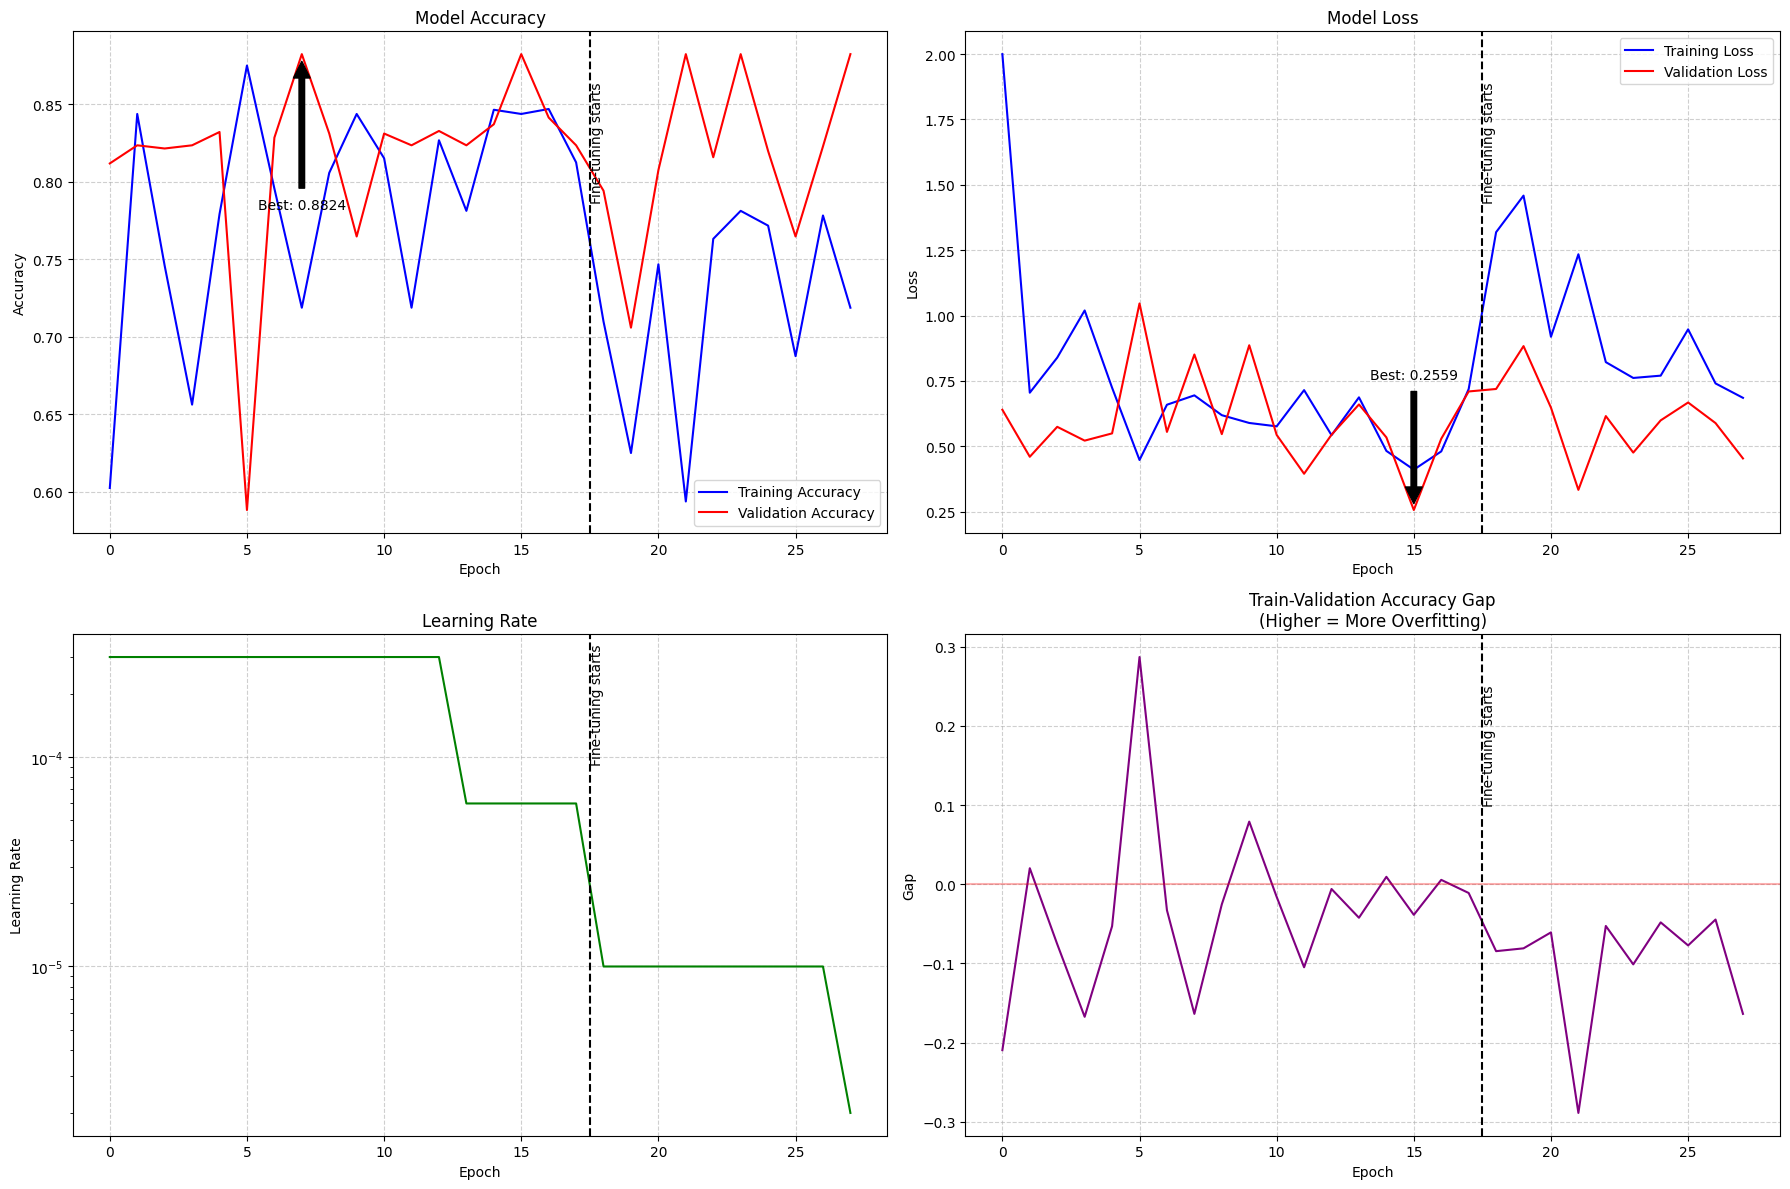

Best validation accuracy: 0.8824 at epoch 8
Best validation loss: 0.2559 at epoch 16


In [15]:
def plot_detailed_training_history(history, fine_tuning_history=None):
    """Plot detailed training metrics with annotations for key points."""
    if fine_tuning_history:
        # Combine histories for continuous plotting
        combined_history = {}
        for key in history.history.keys():
            combined_history[key] = history.history[key] + fine_tuning_history.history[key]
            
        # Create a marker for where fine-tuning begins
        fine_tuning_start = len(history.history['accuracy'])
    else:
        combined_history = history.history
        fine_tuning_start = None
    
    # Create a figure with two rows and two columns
    fig, axs = plt.subplots(2, 2, figsize=(18, 12))
    
    # Accuracy plot (top left)
    axs[0, 0].plot(combined_history['accuracy'], 'b-', label='Training Accuracy')
    axs[0, 0].plot(combined_history['val_accuracy'], 'r-', label='Validation Accuracy')
    
    # Annotate best validation accuracy
    best_val_acc_idx = np.argmax(combined_history['val_accuracy'])
    best_val_acc = combined_history['val_accuracy'][best_val_acc_idx]
    axs[0, 0].annotate(f'Best: {best_val_acc:.4f}', 
                       xy=(best_val_acc_idx, best_val_acc),
                       xytext=(best_val_acc_idx, best_val_acc-0.1),
                       arrowprops=dict(facecolor='black', shrink=0.05),
                       ha='center')
    
    axs[0, 0].set_title('Model Accuracy')
    axs[0, 0].set_ylabel('Accuracy')
    axs[0, 0].set_xlabel('Epoch')
    axs[0, 0].legend(loc='lower right')
    axs[0, 0].grid(True, linestyle='--', alpha=0.6)
    
    # Loss plot (top right)
    axs[0, 1].plot(combined_history['loss'], 'b-', label='Training Loss')
    axs[0, 1].plot(combined_history['val_loss'], 'r-', label='Validation Loss')
    
    # Annotate best validation loss
    best_val_loss_idx = np.argmin(combined_history['val_loss'])
    best_val_loss = combined_history['val_loss'][best_val_loss_idx]
    axs[0, 1].annotate(f'Best: {best_val_loss:.4f}', 
                       xy=(best_val_loss_idx, best_val_loss),
                       xytext=(best_val_loss_idx, best_val_loss+0.5),
                       arrowprops=dict(facecolor='black', shrink=0.05),
                       ha='center')
    
    axs[0, 1].set_title('Model Loss')
    axs[0, 1].set_ylabel('Loss')
    axs[0, 1].set_xlabel('Epoch')
    axs[0, 1].legend(loc='upper right')
    axs[0, 1].grid(True, linestyle='--', alpha=0.6)
    
    # Learning rate plot (bottom left)
    if 'learning_rate' in combined_history:
        axs[1, 0].plot(combined_history['learning_rate'], 'g-')
        axs[1, 0].set_title('Learning Rate')
        axs[1, 0].set_ylabel('Learning Rate')
        axs[1, 0].set_xlabel('Epoch')
        axs[1, 0].set_yscale('log')  # Log scale for better visualization
        axs[1, 0].grid(True, linestyle='--', alpha=0.6)
    else:
        axs[1, 0].set_visible(False)
    
    # Training vs Validation gap plot (bottom right)
    if 'accuracy' in combined_history and 'val_accuracy' in combined_history:
        train_val_gap = [t - v for t, v in zip(combined_history['accuracy'], 
                                              combined_history['val_accuracy'])]
        axs[1, 1].plot(train_val_gap, 'purple')
        axs[1, 1].set_title('Train-Validation Accuracy Gap\n(Higher = More Overfitting)')
        axs[1, 1].set_ylabel('Gap')
        axs[1, 1].set_xlabel('Epoch')
        axs[1, 1].grid(True, linestyle='--', alpha=0.6)
        
        # Add horizontal line at 0
        axs[1, 1].axhline(y=0, color='r', linestyle='-', alpha=0.3)
    else:
        axs[1, 1].set_visible(False)
    
    # If we have fine-tuning data, add a vertical line to mark the transition
    if fine_tuning_start:
        for ax in axs.flatten():
            if ax.get_visible():
                ax.axvline(x=fine_tuning_start-0.5, color='k', linestyle='--', 
                          label='Fine-tuning starts')
                
                # Add text annotation for the phase transition
                ylim = ax.get_ylim()
                y_text = ylim[0] + 0.9 * (ylim[1] - ylim[0])
                ax.text(fine_tuning_start-0.5, y_text, 'Fine-tuning starts', 
                       rotation=90, verticalalignment='top')
    
    plt.tight_layout()
    plt.show()
    
    # Return summary statistics
    return {
        'best_val_accuracy': best_val_acc,
        'best_val_accuracy_epoch': best_val_acc_idx,
        'best_val_loss': best_val_loss,
        'best_val_loss_epoch': best_val_loss_idx
    }

# Call this after training is complete
stats = plot_detailed_training_history(history, history_fine_tuning)
print(f"Best validation accuracy: {stats['best_val_accuracy']:.4f} at epoch {stats['best_val_accuracy_epoch']+1}")
print(f"Best validation loss: {stats['best_val_loss']:.4f} at epoch {stats['best_val_loss_epoch']+1}")